In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 4.0 MB/s 
     |████████████████████████████████| 3.4 MB 16.9 MB/s 
     |████████████████████████████████| 3.3 MB 31.1 MB/s 
     |████████████████████████████████| 1.2 MB 44.3 MB/s 
     |████████████████████████████████| 61 kB 514 kB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=436bddf1aba42457e7d6e755adbdb87ad5a1f84c10a8886c8abea6d8bfdab0a4
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/MyDrive'

import os 
os.chdir(PROJECT_ROOT)
DATA_PATH = os.path.join(PROJECT_ROOT, 'Quotebank_limunADA')

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

from textblob import TextBlob

import torch 
import torch.nn as nn 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt 
import numpy as np 
import scipy
import pickle
import bz2
import json
from operator import itemgetter 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)

    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)

    return lda_tokens


def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


def get_tokens_per_quote(path_to_file, print_step=5e4, num_instances=None):

    tokens_per_quote = {}
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):
            if i % int(print_step) == 0:
                print(f'Instance {i}')

            if num_instances is not None:
                if i == num_instances:
                    break 

            # loading a sample and checking the speaker
            instance = json.loads(instance) 
            tokens = prepare_text_for_lda(instance['quotation'])

            tokens_per_quote[instance['quoteID']] = tokens 
    
    return tokens_per_quote


def get_instances_at_indexes(path_to_file, indexes=None, print_step=5e4):
    instances = []
    # Iterate through the quotes
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, instance in enumerate(s_file):
            if i % int(print_step) == 0:
                print(f'Instance {i}')
                
            if indexes is None or i in indexes:
                instance = json.loads(instance) 
                instances.append(instance['quotation'])
            else:                
                continue 

    return instances



In [5]:
YEAR = '2019'

LOAD_TOKENS_PER_QUOTE = True

path_to_democrates = os.path.join(
    DATA_PATH, f'quotes-democrates-{YEAR}.json.bz2'
    )
path_to_republicans = os.path.join(
    DATA_PATH, f'quotes-republicans-{YEAR}.json.bz2'
    )

os.makedirs(os.path.join(DATA_PATH, 'SBERT'), exist_ok=True) 

path_to_democrates_tokens = os.path.join(
    DATA_PATH, 'SBERT', f'tokens_per_quote_strings_democrates_{YEAR}.pkl'
    )
path_to_republicans_tokens = os.path.join(
    DATA_PATH, 'SBERT', f'tokens_per_quote_strings_republicans_{YEAR}.pkl'
    )

if not LOAD_TOKENS_PER_QUOTE:
    democrates_tokens_per_quote = get_tokens_per_quote(
        path_to_democrates, num_instances=None
        )
    republicans_tokens_per_quote = get_tokens_per_quote(
        path_to_republicans, num_instances=None
        )
    
    democrates_tokens_per_quote_strings = \
        [' '.join(quote) for k, quote in democrates_tokens_per_quote.items()]
    republicans_tokens_per_quote_strings = \
        [' '.join(quote) for k, quote in republicans_tokens_per_quote.items()]

    pickle.dump(
        democrates_tokens_per_quote_strings, 
        open(path_to_democrates_tokens, 'wb')
        )
    pickle.dump(
        republicans_tokens_per_quote_strings, 
        open(path_to_republicans_tokens, 'wb')
        )    

else:
    print('Loading democrates_tokens_per_quote_strings...')
    democrates_tokens_per_quote_strings = pickle.load(
        open(path_to_democrates_tokens, 'rb')
        )
        
    print('Loading republicans_tokens_per_quote_strings...')
    republicans_tokens_per_quote_strings = pickle.load(
        open(path_to_republicans_tokens, 'rb')
        )



Loading democrates_tokens_per_quote_strings...
Loading republicans_tokens_per_quote_strings...


In [6]:
LOAD_QUOTES = True

path_to_democrates_quotes_list = os.path.join(
    DATA_PATH, 'SBERT', f'quotes_list_democrates_{YEAR}.pkl'
    )
path_to_republicans_quotes_list = os.path.join(
    DATA_PATH, 'SBERT', f'quotes_list_republicans_{YEAR}.pkl'
    )

if not LOAD_QUOTES:
    democrates_quotes = get_instances_at_indexes(path_to_democrates)
    republicans_quotes = get_instances_at_indexes(path_to_republicans)

    pickle.dump(
        democrates_quotes, 
        open(path_to_democrates_quotes_list, 'wb')
        ) 
    pickle.dump(
        republicans_quotes, 
        open(path_to_republicans_quotes_list, 'wb')
        ) 
    
else:
    print('Loading democrates_quotes...')
    democrates_quotes = pickle.load(
        open(path_to_democrates_quotes_list, 'rb')
        )
        
    print('Loading republicans_quotes...')
    republicans_quotes = pickle.load(
        open(path_to_republicans_quotes_list, 'rb')
        )



Loading democrates_quotes...
Loading republicans_quotes...


In [7]:
LOAD_ENCODINGS = True

path_to_democrates_embeddings = os.path.join(
    DATA_PATH, 'SBERT', f'embeddings_democrates_{YEAR}.pkl'
    )
path_to_republicans_embeddings = os.path.join(
    DATA_PATH, 'SBERT', f'embeddings_republicans_{YEAR}.pkl'
    )

if not LOAD_ENCODINGS:
    democrates_embeddings = model.encode(
        democrates_tokens_per_quote_strings,
        show_progress_bar=True,
        device=DEVICE,
        batch_size=32 if str(DEVICE) == 'cuda' else 1
        )
    
    republicans_embeddings = model.encode(
        republicans_tokens_per_quote_strings,
        show_progress_bar=True,
        device=DEVICE,
        batch_size=32 if str(DEVICE) == 'cuda' else 1
        )

else:
    print('Loading democrates_embeddings...')
    democrates_embeddings = pickle.load(
        open(path_to_democrates_embeddings, 'rb')
        )
    
    print('Loading republicans_embeddings...')
    republicans_embeddings = pickle.load(
        open(path_to_republicans_embeddings, 'rb')
        )


Loading democrates_embeddings...
Loading republicans_embeddings...


In [8]:
def get_topic_embeddings(topics, model):
    topics_embeddings = model.encode(
        topics, show_progress_bar=True, device=DEVICE, batch_size=1
        )
    
    return topics_embeddings


TOPICS = [
    'economy', 'healthcare', 'education', 'russia', 
    'korea', 'trump', 'china', 'guns', 'budget'
    ]

topics_embeddings = get_topic_embeddings(TOPICS, model)

print(topics_embeddings.shape)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

(9, 384)


In [9]:
compute_cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

democrates_similarities_per_topic = {}
republicans_similarities_per_topic = {}

for topic, topic_embedding in zip(TOPICS, topics_embeddings):
    print(topic)

    democrates_similarities_per_topic[topic] = {}

    democrates_similarities = compute_cosine_similarity(
        torch.from_numpy(democrates_embeddings), 
        torch.from_numpy(topic_embedding)
        )
    
    democrates_similarities_per_topic[topic]['sorted'], \
    democrates_similarities_per_topic[topic]['indexes'] = \
        torch.sort(democrates_similarities, descending=True)

    

    republicans_similarities_per_topic[topic] = {}

    republicans_similarities = compute_cosine_similarity(
        torch.from_numpy(republicans_embeddings), 
        torch.from_numpy(topic_embedding)
        )
    
    republicans_similarities_per_topic[topic]['sorted'], \
    republicans_similarities_per_topic[topic]['indexes'] = \
        torch.sort(republicans_similarities, descending=True)
    

economy
healthcare
education
russia
korea
trump
china
guns
budget


In [10]:
def print_quotes_for_topic(
    all_quotes, 
    topic, 
    similarities_per_topic, 
    num_to_print=None
    ):

    num_quotes = len(similarities_per_topic[topic]['indexes'])
    if num_to_print is None:
        num_to_print = num_quotes
    step = num_quotes / num_to_print

    sampling = np.arange(0, num_quotes-1, step)

    should_keep = list(np.array(
        similarities_per_topic[topic]['indexes'][sampling],
        ))

    kept_similarities = similarities_per_topic[topic]['sorted'][sampling]
    kept_quotes = itemgetter(*should_keep)(all_quotes)

    for i in range(len(kept_quotes)):
        print(f'{kept_similarities[i]} {kept_quotes[i]}')


def get_similar_quotes(all_quotes, similarities_per_topic, topic, threshold):

    should_keep = np.where(
        similarities_per_topic[topic]['sorted'] > threshold
        )[0]

    kept_indexes = similarities_per_topic[topic]['indexes'][should_keep]

    kept_quotes = itemgetter(*kept_indexes)(all_quotes)

    return kept_quotes




## Education

We printed totally 1000 quotations. Rough estimation for a good treshold would be 0.37.

In [27]:
print_quotes_for_topic(
    democrates_quotes, 'education', democrates_similarities_per_topic, 1000
    )

# TOPICS = [
#     'economy', 'healthcare', 'education': 0.37, 'russia', 
#     'korea', 'trump', 'china', 'guns', 'budget'
#     ]

In [11]:
print_quotes_for_topic(
    republicans_quotes, 'education', republicans_similarities_per_topic, 1000
    )


In [12]:
democrates_quotes_education = get_similar_quotes(
    democrates_quotes, democrates_similarities_per_topic, 'education', 0.37
    )

In [13]:
# model = TextBlob()

scores_democrates = np.array(
    [TextBlob(quote).sentiment.polarity for quote in democrates_quotes_education]
    )
np.mean(scores_democrates)


0.1509490464990627

In [14]:
republicans_quotes_education = get_similar_quotes(
    republicans_quotes, republicans_similarities_per_topic, 'education', 0.37
    )

In [15]:
scores_republicans = np.array(
    [TextBlob(quote).sentiment.polarity for quote in republicans_quotes_education]
    )
np.mean(scores_republicans)

0.1651608402924654

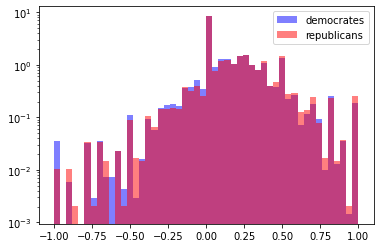

In [18]:
plt.hist(scores_democrates, alpha=0.5, color='b', label='democrates', bins=50, density=True, log=True)
plt.hist(scores_republicans, alpha=0.5, color='r', label='republicans', bins=50, density=True, log=True)
plt.legend()



## Trump

In [ ]:
THRESHOLDS_DICT = {'education': 0.37, 'trump': None}

democrates_quotes_per_topic = {}
